# Introduction

Thank you all for participating in the Smart Droplets Hackathon!
It was fantastic to see everyone’s contributions and creative solutions. In total, we had participants from three different universities and we received 19 submissions: 11 Reinforcement Learning agents and 8 Conditional agents.

Results:

*   🥇 SmartestConditionalFarmer — Thijs van der Plas
*   🥈 ConstantSprayer — Eva van Tegelen
*   🥉 SprayAndPray — Eray Onler

Below you’ll find the code to run each agent and visualize their policies.
The held-out evaluation location is an apple orchard in France: (44.0986, 1.1628).

In [ ]:
# Run this cell to set up the environment

import os
import sys
import subprocess

# Clone the repository
!rm -rf A-scab/
!git clone -b hackathon https://github.com/WUR-AI/A-scab.git

# Change directory
%cd A-scab

# Get the absolute path of the project root *after* changing directory
PROJECT_ROOT = os.getcwd()

# Install poetry if needed.
!pip install -qqq poetry

# Configure poetry to create virtual environments in the project directory
!poetry config virtualenvs.in-project true

# Install project dependencies
# This step may take some time (e.g., 5 minutes)
!poetry install --quiet --all-extras

# These are things you don't need to know about for now :)

# 1. Add the project root to sys.path
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
    print(f"Added project root {PROJECT_ROOT} to sys.path")

# 2. Get the path to the site-packages directory of the poetry virtual environment
try:
    venv_path_output = subprocess.check_output(['poetry', 'env', 'info', '--path']).decode('utf-8').strip()
    python_version_major_minor = f"python{sys.version_info.major}.{sys.version_info.minor}"
    SITE_PACKAGES_PATH = os.path.join(venv_path_output, 'lib', python_version_major_minor, 'site-packages')
except Exception as e:
    print(f"Could not determine poetry venv site-packages path using 'poetry env info': {e}")
    print("Attempting a common fallback path structure...")
    SITE_PACKAGES_PATH = os.path.abspath(os.path.join('.venv', 'lib', f'python{sys.version_info.major}.{sys.version_info.minor}', 'site-packages'))

# 3. Add the site-packages directory to sys.path
if os.path.exists(SITE_PACKAGES_PATH) and SITE_PACKAGES_PATH not in sys.path:
    sys.path.insert(0, SITE_PACKAGES_PATH)
    print(f"Added {SITE_PACKAGES_PATH} to sys.path")
else:
    print(f"Warning: Could not find site-packages at {SITE_PACKAGES_PATH} or it's already in sys.path.")

import ascab
import gymnasium as gym

# Conditional Agents

In [2]:
from ascab.train import BaseAgent
from ascab.env.env import AScabEnv, MultipleWeatherASCabEnv, get_weather_library, get_default_start_of_season, get_default_end_of_season
from ascab.utils.generic import get_dates

ascab_val = MultipleWeatherASCabEnv(
        weather_data_library=get_weather_library(
            locations=[(44.0986, 1.1628)],
            dates=get_dates([year for year in range(2016, 2025) if year % 2 != 0], start_of_season=get_default_start_of_season(), end_of_season=get_default_end_of_season())),
        biofix_date="March 10",
        budbreak_date="March 10",
        mode="sequential",
    )

In [18]:
class SmartLittleSprayer(BaseAgent):
    def __init__(
        self,
        ascab: AScabEnv = None,
        render: bool = True,
    ):
        super().__init__(ascab=ascab, render=render)

    def get_action(self, observation: dict = None) -> float:
        # Please include this check for all your conditional agents to constrain it within the "risk period".
        if self.ascab.get_wrapper_attr("info")["InfectionWindow"] and self.ascab.get_wrapper_attr("info")["InfectionWindow"][-1] == 1:
            # The code below means: "If it is forecasted that it will rain in two days, I will spray today".
            if self.ascab.get_wrapper_attr("info")["Forecast_day2_HasRain"] and self.ascab.get_wrapper_attr("info")["Forecast_day2_HasRain"][-1]:
              # Last spray was three 4 days ago
              if self.ascab.get_wrapper_attr("info")["SinceLastAction"] and self.ascab.get_wrapper_attr("info")["SinceLastAction"][-1]>4:
                return 0.8  # the agent sprays this much if is forecasted to rain in two days
        return 0.0

SmartLittleSprayer_agent = SmartLittleSprayer(ascab_val,render=False)

# Use the class method below to run your agent!
SmartLittleSprayer_results = SmartLittleSprayer_agent.run()
print(f"Total reward for SmartLittleSprayer: {float(SmartLittleSprayer_results.Reward.sum())}")

Reward: -0.22878573999811397
Reward: -0.15597893472097596
Reward: -0.14365786863494673
Reward: -0.20520014921462454
Total reward for SmartLittleSprayer: -0.7336226925686613


In [55]:
class ConstantSprayer(BaseAgent):
    def __init__(
        self,
        ascab: AScabEnv = None,
        render: bool = True,
    ):
        super().__init__(ascab=ascab, render=render)

    def get_action(self, observation: dict = None) -> float:
        # Please include this check for all your conditional agents to constrain it within the "risk period".
        if self.ascab.get_wrapper_attr("info")["InfectionWindow"] and self.ascab.get_wrapper_attr("info")["InfectionWindow"][-1] == 1:
            forecast_rain = self.ascab.get_wrapper_attr("info")["Forecast_day1_HasRain"][-1]
            forecast_precipitation = self.ascab.get_wrapper_attr("info")["Forecast_day1_Precipitation"][-1]
            discharge = self.ascab.get_wrapper_attr("info")["Discharge"][-1]

            precipitation_weight = 0.5+forecast_precipitation/100
            discharge_weight =  discharge/0.5

            if forecast_rain==1:
              return 0.12+discharge_weight*precipitation_weight*0.15
            return 0.015
        return 0

ConstantSprayer_strategy = ConstantSprayer(ascab_val, render=False)

# Use the class method below to run your agent!
ConstantSprayer_results = ConstantSprayer_strategy.run()
print(f"Total reward for ConstantSprayer: {float(ConstantSprayer_results.Reward.sum())}")

Reward: -0.09063523124871865
Reward: -0.12584669146612368
Reward: -0.09688076770084598
Reward: -0.09314312913620483
Total reward for ConstantSprayer: -0.4065058195518931


In [20]:
class SmartestConditionalFarmer(BaseAgent):
    def __init__(
        self,
        ascab: AScabEnv = None,
        render: bool = True,
    ):
        super().__init__(ascab=ascab, render=render)

    def checker_return_last(self, name_attr: str):
        """
        Check if the attribute exists in the ascab environment.
        """
        if self.ascab.get_wrapper_attr("info")[name_attr]:
            return self.ascab.get_wrapper_attr("info")[name_attr][-1]
        else:
            return None

    def get_action(self, observation: dict = None) -> float:
        # Please include this check for all your conditional agents to constrain it within the "risk period".
        if (self.checker_return_last("InfectionWindow") == 1 and self.checker_return_last('Forecast_day2_HasRain')
            and self.checker_return_last('SinceLastAction') and self.checker_return_last('Temperature') > 10):
            return min(0.25, self.checker_return_last('SinceLastAction') / 10)
        return 0.0

SmartestConditionalFarmer_strategy = SmartestConditionalFarmer(ascab_val, render=False)

# Use the class method below to run your agent!
SmartestConditionalFarmer_results = SmartestConditionalFarmer_strategy.run()
print(f"Total reward for SmartestConditionalFarmer: {float(SmartestConditionalFarmer_results.Reward.sum())}")

Reward: -0.12049697268931689
Reward: -0.07474176130739009
Reward: -0.07443392213299443
Reward: -0.12478029178530267
Total reward for SmartestConditionalFarmer: -0.39445294791500407


In [21]:
class SmartestAndGreatestConditionalFarmer(BaseAgent):
    def __init__(
        self,
        ascab: AScabEnv = None,
        render: bool = True,
        precip_day2_treshold = 1.5,  # Threshold for precipitation in two days
        min_temp = 10.0,  # Minimum temperature to consider spraying
        max_spray_amount = 0.28603505,  # Maximum spray amount
        spray_factor = 13.97833967  # Factor to scale the spray amount based on time since last action
    ):
        super().__init__(ascab=ascab, render=render)
        self.min_temp = min_temp
        self.max_spray_amount = max_spray_amount
        self.spray_factor = spray_factor
        self.precip_day2_treshold = precip_day2_treshold

    def checker_return_last(self, name_attr: str):
        """
        Check if the attribute exists in the ascab environment.
        """
        if self.ascab.get_wrapper_attr("info")[name_attr]:
            return self.ascab.get_wrapper_attr("info")[name_attr][-1]
        else:
            return None

    def get_action(self, observation: dict = None) -> float:
        if self.checker_return_last("InfectionWindow") == 1 and self.checker_return_last('SinceLastAction'):
            if self.checker_return_last('Forecast_day2_Precipitation') > self.precip_day2_treshold and self.checker_return_last('Temperature') > self.min_temp:
                return min(self.max_spray_amount, self.checker_return_last('SinceLastAction') / self.spray_factor)
        return 0.0

SmartestAndGreatestConditionalFarmer_strategy = SmartestAndGreatestConditionalFarmer(ascab_val, render=False)

# Use the class method below to run your agent!
SmartestAndGreatestConditionalFarmer_results = SmartestAndGreatestConditionalFarmer_strategy.run()
print(f"Total reward for SmartestAndGreatestConditionalFarmer: {float(SmartestAndGreatestConditionalFarmer_results.Reward.sum())}")

Reward: -0.14368346687355188
Reward: -0.0734590904076867
Reward: -0.0692068399848814
Reward: -0.13361383231325008
Total reward for SmartestAndGreatestConditionalFarmer: -0.41996322957937005


In [17]:
class SmartLittleSprayer2(BaseAgent):
    def __init__(
        self,
        ascab: AScabEnv = None,
        render: bool = True,
    ):
        super().__init__(ascab=ascab, render=render)

    def get_action(self, observation: dict = None) -> float:
        # Please include this check for all your conditional agents to constrain it within the "risk period".
        if self.ascab.get_wrapper_attr("info")["InfectionWindow"] and self.ascab.get_wrapper_attr("info")["InfectionWindow"][-1] == 1:
            # The code below means: "If it is forecasted that it will rain in two days, I will spray today".
            if self.ascab.get_wrapper_attr("info")["Forecast_day2_HasRain"] and self.ascab.get_wrapper_attr("info")["Forecast_day2_HasRain"][-1]:
              # Last spray was three 5 days ago
              if self.ascab.get_wrapper_attr("info")["SinceLastAction"] and self.ascab.get_wrapper_attr("info")["SinceLastAction"][-1]>4:
                LAI = self.ascab.get_wrapper_attr("info")["LAI"][-1]
                return LAI/5*0.8  # the agent sprays this much if is forecasted to rain in two days
        return 0.0

SmartLittleSprayer2_strategy = SmartLittleSprayer2(ascab_val,render=False)

# Use the class method below to run your agent!
SmartLittleSprayer2_results = SmartLittleSprayer2_strategy.run()
print(f"Total reward for SmartLittleSprayer2: {float(SmartLittleSprayer2_results.Reward.sum())}")

Reward: -0.17419657994808985
Reward: -0.15765718149820243
Reward: -0.15829377958153784
Reward: -0.25855675806136463
Total reward for SmartLittleSprayer2: -0.7487042990891947


In [34]:
import numpy as np
np.random.seed(42)

class DefinitiveSuperProSprayer(BaseAgent):
    def __init__(
        self,
        ascab: AScabEnv = None,
        render: bool = True,
    ):
        super().__init__(ascab=ascab, render=render)

    def get_action(self, observation: dict = None) -> float:
        # Please include this check for all your conditional agents to constrain it within the "risk period".
        if self.ascab.get_wrapper_attr("info")["InfectionWindow"] and self.ascab.get_wrapper_attr("info")["InfectionWindow"][-1] == 1:
            # The code below means: "If it is forecasted that it will rain in two days, I will spray today".
            if self.ascab.get_wrapper_attr("info")["Forecast_day2_HasRain"] and self.ascab.get_wrapper_attr("info")["Forecast_day2_HasRain"][-1]:
              if self.ascab.get_wrapper_attr("info")["Forecast_day1_HasRain"] and self.ascab.get_wrapper_attr("info")["Forecast_day1_HasRain"][-1]:
                if not (self.ascab.get_wrapper_attr("info")["HasRain"] and self.ascab.get_wrapper_attr("info")["HasRain"][-1]):
                  return 1.
            return np.random.beta(2., 16)
        return 0.0

DefinitiveSuperProSprayer_strategy = DefinitiveSuperProSprayer(ascab_val, render=False)

# Use the class method below to run your agent!
DefinitiveSuperProSprayer_results = DefinitiveSuperProSprayer_strategy.run()
print(f"Total reward for DefinitiveSuperProSprayer: {float(DefinitiveSuperProSprayer_results.Reward.sum())}")

Reward: -0.31169212312062544
Reward: -0.3352347013756098
Reward: -0.3183108122362305
Reward: -0.2692835919901125
Total reward for DefinitiveSuperProSprayer: -1.2345212287225782


In [37]:
class MagicCondition(BaseAgent):
    def __init__(
        self,
        ascab: AScabEnv = None,
        render: bool = False,
    ):
        super().__init__(ascab=ascab, render=render)

    def get_action(self, observation: dict = None) -> float:
        # Please include this check for all your conditional agents to constrain it within the "risk period".
        if self.ascab.get_wrapper_attr("info")["InfectionWindow"] and self.ascab.get_wrapper_attr("info")["InfectionWindow"][-1] == 1:
            # The code below means: "If it is forecasted that it will rain in two days, I will spray today".
            if self.ascab.get_wrapper_attr("info")["Forecast_day1_HasRain"] and self.ascab.get_wrapper_attr("info")["Forecast_day1_HasRain"][-1]:
                return 0.6  # the agent sprays this much if is forecasted to rain in two days
            if self.ascab.get_wrapper_attr("info")["Forecast_day1_HasRain"][-1] and self.ascab.get_wrapper_attr("info")["Forecast_day2_Temperature"][-1]>20:
                return 0.5
        return 0.0

MagicCondition_strategy = MagicCondition(ascab_val)

# Use the class method below to run your agent!
MagicCondition_results = MagicCondition_strategy.run()
print(f"Total reward for MagicCondition: {float(MagicCondition_results.Reward.sum())}")

Reward: -0.270020565823939
Reward: -0.37374478946336304
Reward: -0.33136514668561234
Reward: -0.2854126323588202
Total reward for MagicCondition: -1.2605431343317344


In [36]:
import numpy as np
np.random.seed(42)

class NotSoSmartRandomConditionalAgent(BaseAgent):
    def __init__(
        self,
        ascab: AScabEnv = None,
        render: bool = False,
    ):
        super().__init__(ascab=ascab, render=render)

    def get_action(self, observation: dict = None) -> float:
        # Please include this check for all your conditional agents to constrain it within the "risk period".
        if self.ascab.get_wrapper_attr("info")["InfectionWindow"] and self.ascab.get_wrapper_attr("info")["InfectionWindow"][-1] == 1:
            import numpy as np
            np.random.seed(42)
            return np.random.beta(1, 16)
        return 0.0

NotSoSmartRandomConditionalAgent_strategy = NotSoSmartRandomConditionalAgent(ascab_val)
NotSoSmartRandomConditionalAgent_results = NotSoSmartRandomConditionalAgent_strategy.run()
print(f"Total reward for NotSoSmartRandomConditionalAgent: {float(NotSoSmartRandomConditionalAgent_results.Reward.sum())}")

Reward: -0.1345920869066652
Reward: -0.18584853917200303
Reward: -0.14364933598530671
Reward: -0.11251415131715134
Total reward for NotSoSmartRandomConditionalAgent: -0.5766041133811264


# RL agents

In [40]:
from stable_baselines3 import PPO, SAC, TD3, DQN, HER, A2C
from ascab.train import BaseAgent, RLAgent
from ascab.env.env import AScabEnv, MultipleWeatherASCabEnv, get_weather_library, get_default_start_of_season, get_default_end_of_season
from ascab.utils.generic import get_dates


In [41]:
algo=A2C

ascab_val_discrete = MultipleWeatherASCabEnv(
        weather_data_library=get_weather_library(
            locations=[(44.0986, 1.1628)],
            dates=get_dates([year for year in range(2016, 2025) if year % 2 != 0], start_of_season=get_default_start_of_season(), end_of_season=get_default_end_of_season())),
        biofix_date="March 10",
        budbreak_date="March 10",
        mode="sequential",
        discrete_actions = True
    )

observation_filter=list(ascab_val_discrete.observation_space.keys())

SoCalledSprayer = RLAgent(
    rl_algorithm=algo,
    observation_filter=list(ascab_val_discrete.observation_space.keys()),
    ascab_test=ascab_val_discrete,
    path_model='/content/A-scab/hackathon/models/SoCalledSprayer',
)
SoCalledSprayer_results = SoCalledSprayer.run()
print(f"Total reward for SoCalledSprayer: {float(SoCalledSprayer_results.Reward.sum())}")


Training environment is not provided; going into evaluation mode!...
Filter observations: ['ActionHistory', 'AppliedPesticide', 'Beta', 'Discharge', 'Forecast_day1_HasRain', 'Forecast_day1_HumidDuration', 'Forecast_day1_LeafWetness', 'Forecast_day1_Precipitation', 'Forecast_day1_Temperature', 'Forecast_day2_HasRain', 'Forecast_day2_HumidDuration', 'Forecast_day2_LeafWetness', 'Forecast_day2_Precipitation', 'Forecast_day2_Temperature', 'HasRain', 'HumidDuration', 'InfectionWindow', 'LAI', 'LeafWetness', 'Precipitation', 'RemainingSprays', 'SinceLastAction', 'Temperature']
Checking if model exists in path_model...
Found it!
Load model from disk: /content/SoCalledSprayer
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Load normalization parameters from disk: /content/SoCalledSprayer_norm.pkl
Running trained model in A-scab environment...!
Reward: [-0.48572287]
Reward: [-0.5790746]
Reward: [-0.26683494]
Reward: [-0.54361427]
Reward: [-0.48572287]
Reward: [-0.57

In [42]:
algo=PPO
# Use the SAME observation filter as during training (19 observations)
training_observation_filter = ['ActionHistory', 'AppliedPesticide', 'Beta', 'Discharge',
                              'Forecast_day1_HasRain', 'Forecast_day1_HumidDuration',
                              'Forecast_day1_Temperature', 'Forecast_day2_HasRain',
                              'Forecast_day2_HumidDuration', 'Forecast_day2_Temperature',
                              'HasRain', 'HumidDuration', 'InfectionWindow', 'LAI',
                              'LeafWetness', 'Precipitation', 'RemainingSprays',
                              'SinceLastAction', 'Temperature']

ascab_val_discrete = MultipleWeatherASCabEnv(
        weather_data_library=get_weather_library(
            locations=[(44.0986, 1.1628)],
            dates=get_dates([year for year in range(2016, 2025) if year % 2 != 0], start_of_season=get_default_start_of_season(), end_of_season=get_default_end_of_season())),
        biofix_date="March 10",
        budbreak_date="March 10",
        mode="sequential",
        discrete_actions = True
    )

SprayAndPray4 = RLAgent(
    rl_algorithm=algo,
    observation_filter=training_observation_filter,
    ascab_test=ascab_val_discrete,
    path_model='/content/A-scab/hackathon/models/SprayAndPray4',
)
SprayAndPray4_results = SprayAndPray4.run()
print(f"Total reward for SprayAndPray4: {float(SprayAndPray4_results.Reward.sum())}")

Training environment is not provided; going into evaluation mode!...
Filter observations: ['ActionHistory', 'AppliedPesticide', 'Beta', 'Discharge', 'Forecast_day1_HasRain', 'Forecast_day1_HumidDuration', 'Forecast_day1_Temperature', 'Forecast_day2_HasRain', 'Forecast_day2_HumidDuration', 'Forecast_day2_Temperature', 'HasRain', 'HumidDuration', 'InfectionWindow', 'LAI', 'LeafWetness', 'Precipitation', 'RemainingSprays', 'SinceLastAction', 'Temperature']
Overriding observation space with defined observation filter!
Checking if model exists in path_model...
Found it!
Load model from disk: /content/SprayAndPray4
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Load normalization parameters from disk: /content/SprayAndPray4_norm.pkl
Running trained model in A-scab environment...!
Reward: [-0.18416673]
Reward: [-0.38354975]
Reward: [-0.3249076]
Reward: [-0.15639924]
Reward: [-0.18416673]
Reward: [-0.38354975]
Reward: [-0.3249076]
Reward: [-0.15639924]
Total rewar

In [48]:
algo=PPO

ascab_val_discrete = MultipleWeatherASCabEnv(
        weather_data_library=get_weather_library(
            locations=[(44.0986, 1.1628)],
            dates=get_dates([year for year in range(2016, 2025) if year % 2 != 0], start_of_season=get_default_start_of_season(), end_of_season=get_default_end_of_season())),
        biofix_date="March 10",
        budbreak_date="March 10",
        mode="sequential",
        discrete_actions = True
    )

SprayAndPray1 = RLAgent(
    rl_algorithm=algo,
    observation_filter=list(ascab_val_discrete.observation_space.keys()),
    ascab_test=ascab_val_discrete,
    path_model='/content/A-scab/hackathon/models/SprayAndPray1',
)
SprayAndPray1_results = SprayAndPray1.run()
print(f"Total reward for SprayAndPray1: {float(SprayAndPray1_results.Reward.sum())}")

Training environment is not provided; going into evaluation mode!...
Filter observations: ['ActionHistory', 'AppliedPesticide', 'Beta', 'Discharge', 'Forecast_day1_HasRain', 'Forecast_day1_HumidDuration', 'Forecast_day1_LeafWetness', 'Forecast_day1_Precipitation', 'Forecast_day1_Temperature', 'Forecast_day2_HasRain', 'Forecast_day2_HumidDuration', 'Forecast_day2_LeafWetness', 'Forecast_day2_Precipitation', 'Forecast_day2_Temperature', 'HasRain', 'HumidDuration', 'InfectionWindow', 'LAI', 'LeafWetness', 'Precipitation', 'RemainingSprays', 'SinceLastAction', 'Temperature']
Checking if model exists in path_model...
Found it!
Load model from disk: /content/SprayAndPray1
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Load normalization parameters from disk: /content/SprayAndPray1_norm.pkl
Running trained model in A-scab environment...!
Reward: [-0.18309319]
Reward: [-0.14542156]
Reward: [-0.13521853]
Reward: [-0.16013673]
Reward: [-0.18309319]
Reward: [-0.14542

In [49]:
algo=PPO
ascab_val_discrete = MultipleWeatherASCabEnv(
        weather_data_library=get_weather_library(
            locations=[(44.0986, 1.1628)],
            dates=get_dates([year for year in range(2016, 2025) if year % 2 != 0], start_of_season=get_default_start_of_season(), end_of_season=get_default_end_of_season())),
        biofix_date="March 10",
        budbreak_date="March 10",
        mode="sequential",
        discrete_actions = True
    )

EatEvenMoreApples = RLAgent(
    rl_algorithm=algo,
    observation_filter=list(ascab_val_discrete.observation_space.keys()),
    ascab_test=ascab_val_discrete,
    path_model='/content/A-scab/hackathon/models/EatEvenMoreApples',
)
EatEvenMoreApples_results = EatEvenMoreApples.run()
print(f"Total reward for EatEvenMoreApples: {float(EatEvenMoreApples_results.Reward.sum())}")

Training environment is not provided; going into evaluation mode!...
Filter observations: ['ActionHistory', 'AppliedPesticide', 'Beta', 'Discharge', 'Forecast_day1_HasRain', 'Forecast_day1_HumidDuration', 'Forecast_day1_LeafWetness', 'Forecast_day1_Precipitation', 'Forecast_day1_Temperature', 'Forecast_day2_HasRain', 'Forecast_day2_HumidDuration', 'Forecast_day2_LeafWetness', 'Forecast_day2_Precipitation', 'Forecast_day2_Temperature', 'HasRain', 'HumidDuration', 'InfectionWindow', 'LAI', 'LeafWetness', 'Precipitation', 'RemainingSprays', 'SinceLastAction', 'Temperature']
Checking if model exists in path_model...
Found it!
Load model from disk: /content/EatEvenMoreApples
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Load normalization parameters from disk: /content/EatEvenMoreApples_norm.pkl
Running trained model in A-scab environment...!
Reward: [-0.11733181]
Reward: [-0.18652768]
Reward: [-0.1043637]
Reward: [-0.14812703]
Reward: [-0.11733181]
Reward: [-

In [52]:
from sb3_contrib import RecurrentPPO
ascab_val_discrete = MultipleWeatherASCabEnv(
        weather_data_library=get_weather_library(
            locations=[(44.0986, 1.1628)],
            dates=get_dates([year for year in range(2016, 2025) if year % 2 != 0], start_of_season=get_default_start_of_season(), end_of_season=get_default_end_of_season())),
        biofix_date="March 10",
        budbreak_date="March 10",
        mode="sequential",
        discrete_actions = True
    )
algo=RecurrentPPO
observation_filter = ['ActionHistory', 'AppliedPesticide', 'Beta', 'Discharge', 'Forecast_day1_HasRain', 'Forecast_day1_HumidDuration', 'Forecast_day1_LeafWetness', 'Forecast_day1_Precipitation', 'Forecast_day1_Temperature', 'Forecast_day2_HasRain', 'Forecast_day2_HumidDuration', 'Forecast_day2_LeafWetness', 'Forecast_day2_Precipitation', 'Forecast_day2_Temperature', 'HasRain', 'HumidDuration', 'InfectionWindow', 'LAI', 'LeafWetness', 'Precipitation', 'RemainingSprays', 'Temperature']

BeatHilmy = RLAgent(
    rl_algorithm=algo,
    observation_filter=observation_filter,
    ascab_test=ascab_val_discrete,
    path_model='/content/A-scab/hackathon/models/BeatHilmy',
)
BeatHilmy_results = BeatHilmy.run()
print(f"Total reward for BeatHilmy: {float(BeatHilmy_results.Reward.sum())}")

Training environment is not provided; going into evaluation mode!...
Filter observations: ['ActionHistory', 'AppliedPesticide', 'Beta', 'Discharge', 'Forecast_day1_HasRain', 'Forecast_day1_HumidDuration', 'Forecast_day1_LeafWetness', 'Forecast_day1_Precipitation', 'Forecast_day1_Temperature', 'Forecast_day2_HasRain', 'Forecast_day2_HumidDuration', 'Forecast_day2_LeafWetness', 'Forecast_day2_Precipitation', 'Forecast_day2_Temperature', 'HasRain', 'HumidDuration', 'InfectionWindow', 'LAI', 'LeafWetness', 'Precipitation', 'RemainingSprays', 'Temperature']
Overriding observation space with defined observation filter!
Checking if model exists in path_model...
Found it!
Load model from disk: /content/BeatHilmy
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Load normalization parameters from disk: /content/BeatHilmy_norm.pkl
Running trained model in A-scab environment...!
Reward: [-0.07217193]
Reward: [-0.12480461]
Reward: [-0.07300267]
Reward: [-0.1144531]
Rewar

In [59]:
from gymnasium import spaces

class FeatureEngineeringWrapper(gym.ObservationWrapper):
    """
    Wrapper that adds engineered features to the observation space
    """
    def __init__(self, env):
        super().__init__(env)

        # Get original observation space
        if hasattr(env.observation_space, 'spaces'):
            # Dict observation space
            self.is_dict_space = True
            self.original_keys = list(env.observation_space.spaces.keys())
            # Calculate total size of flattened dict observations
            self.original_obs_size = 0
            for space in env.observation_space.spaces.values():
                if hasattr(space, 'shape'):
                    if len(space.shape) == 0:  # Scalar
                        self.original_obs_size += 1
                    elif len(space.shape) == 1:  # 1D array
                        self.original_obs_size += space.shape[0]
                    else:  # Multi-dimensional - flatten
                        self.original_obs_size += np.prod(space.shape)
                else:
                    self.original_obs_size += 1
        else:
            # Box observation space
            self.is_dict_space = False
            if hasattr(env.observation_space, 'shape'):
                if len(env.observation_space.shape) == 0:
                    self.original_obs_size = 1
                elif len(env.observation_space.shape) == 1:
                    self.original_obs_size = env.observation_space.shape[0]
                else:
                    self.original_obs_size = np.prod(env.observation_space.shape)
            else:
                self.original_obs_size = 1

        # Calculate new observation space size (original + engineered features)
        self.engineered_features_size = 15  # Total engineered features
        new_obs_size = self.original_obs_size + self.engineered_features_size

        # Update observation space to Box (flattened)
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(new_obs_size,),
            dtype=np.float32
        )

        # Initialize feature history for trend calculation
        self.feature_history = []
        self.max_history = 10

    def _flatten_obs(self, obs):
        """Flatten dict observation to array"""
        if self.is_dict_space:
            flattened = []
            for key in self.original_keys:
                if key in obs:
                    val = obs[key]
                    if isinstance(val, (int, float)):
                        flattened.append(float(val))
                    elif hasattr(val, '__iter__') and not isinstance(val, str):
                        # Handle arrays/lists - flatten them
                        val_array = np.array(val).flatten()
                        flattened.extend(val_array.astype(float))
                    else:
                        flattened.append(float(val))
                else:
                    # Handle missing keys with default value
                    flattened.append(0.0)
            return np.array(flattened, dtype=np.float32)
        else:
            # Handle Box space
            if hasattr(obs, 'flatten'):
                return obs.flatten().astype(np.float32)
            else:
                return np.array(obs, dtype=np.float32).flatten()

    def create_infection_risk_score(self, obs):
        """Create infection risk score based on weather and population density"""
        try:
            # Extract relevant indices (adjust based on your actual observation structure)
            temperature = obs[0] if len(obs) > 0 else 20.0
            humidity = obs[1] if len(obs) > 1 else 0.5
            population_density = obs[2] if len(obs) > 2 else 1.0

            # Risk increases with optimal temperature (20-30°C) and high humidity
            temp_risk = 1.0 - abs(temperature - 25.0) / 25.0
            temp_risk = max(0, temp_risk)

            humidity_risk = humidity
            density_risk = min(population_density / 10.0, 1.0)

            infection_risk = (temp_risk * 0.4 + humidity_risk * 0.4 + density_risk * 0.2)
            return np.clip(infection_risk, 0, 1)
        except:
            return 0.5

    def create_spray_timing_features(self, obs):
        """Create features related to optimal spray timing"""
        try:
            # Extract weather conditions
            temperature = obs[0] if len(obs) > 0 else 20.0
            wind_speed = obs[3] if len(obs) > 3 else 5.0
            precipitation = obs[4] if len(obs) > 4 else 0.0

            # Optimal spray conditions: moderate temp, low wind, no rain
            temp_suitability = 1.0 - abs(temperature - 22.0) / 30.0
            temp_suitability = max(0, temp_suitability)

            wind_suitability = max(0, 1.0 - wind_speed / 20.0)
            rain_penalty = max(0, 1.0 - precipitation * 2.0)

            spray_timing_score = temp_suitability * wind_suitability * rain_penalty

            return [
                spray_timing_score,
                temp_suitability,
                wind_suitability
            ]
        except:
            return [0.5, 0.5, 0.5]

    def create_weather_trends(self, obs):
        """Create weather trend features"""
        try:
            current_weather = obs[:5] if len(obs) >= 5 else [20.0, 0.5, 1.0, 5.0, 0.0]

            if len(self.feature_history) < 2:
                return [0.0, 0.0, 0.0]

            # Calculate trends over last few observations
            recent_weather = np.array([h[:5] for h in self.feature_history[-3:]])

            temp_trend = np.polyfit(range(len(recent_weather)), recent_weather[:, 0], 1)[0]
            humidity_trend = np.polyfit(range(len(recent_weather)), recent_weather[:, 1], 1)[0]
            wind_trend = np.polyfit(range(len(recent_weather)), recent_weather[:, 3], 1)[0]

            return [
                np.clip(temp_trend, -1, 1),
                np.clip(humidity_trend, -1, 1),
                np.clip(wind_trend, -1, 1)
            ]
        except:
            return [0.0, 0.0, 0.0]

    def create_forecast_features(self, obs):
        """Create simple forecast-based features"""
        try:
            # Simple forecast based on current conditions and trends
            if len(self.feature_history) < 2:
                return [0.5, 0.5]

            current_infection_risk = self.create_infection_risk_score(obs)
            spray_features = self.create_spray_timing_features(obs)

            # Forecast infection risk (simple momentum-based)
            risk_momentum = current_infection_risk
            if len(self.feature_history) >= 2:
                prev_risk = self.feature_history[-1][-2] if len(self.feature_history[-1]) > 2 else 0.5
                risk_momentum = current_infection_risk + 0.3 * (current_infection_risk - prev_risk)

            forecasted_risk = np.clip(risk_momentum, 0, 1)
            spray_urgency = max(0, forecasted_risk - spray_features[0])

            return [forecasted_risk, spray_urgency]
        except:
            return [0.5, 0.5]

    def create_economic_features(self, obs):
        """Create economic impact features"""
        try:
            # Extract relevant economic indicators from observation
            population_density = obs[2] if len(obs) > 2 else 1.0
            infection_risk = self.create_infection_risk_score(obs)

            # Economic impact increases with population and infection risk
            economic_impact = population_density * infection_risk * 0.1

            # Cost-benefit of spraying
            spray_cost = 0.1  # Base spray cost
            potential_damage = infection_risk * population_density * 0.2
            cost_benefit_ratio = potential_damage / (spray_cost + 1e-6)

            return [
                np.clip(economic_impact, 0, 1),
                np.clip(cost_benefit_ratio, 0, 5)
            ]
        except:
            return [0.1, 1.0]

    def create_interaction_features(self, obs):
        """Create interaction features between different variables"""
        try:
            temperature = obs[0] if len(obs) > 0 else 20.0
            humidity = obs[1] if len(obs) > 1 else 0.5
            population_density = obs[2] if len(obs) > 2 else 1.0
            wind_speed = obs[3] if len(obs) > 3 else 5.0

            # Weather interaction (temperature * humidity)
            weather_interaction = (temperature / 30.0) * humidity

            # Population-weather interaction
            pop_weather_interaction = population_density * humidity * (temperature / 30.0)

            # Spray effectiveness (inverse of wind speed * weather suitability)
            spray_effectiveness = (1.0 / (wind_speed + 1)) * weather_interaction

            return [
                np.clip(weather_interaction, 0, 1),
                np.clip(pop_weather_interaction, 0, 2),
                np.clip(spray_effectiveness, 0, 1)
            ]
        except:
            return [0.5, 1.0, 0.5]

    def observation(self, obs):
        """Add engineered features to observation"""
        # Flatten observation if it's a dict
        flat_obs = self._flatten_obs(obs)

        # Store current observation for trend calculation
        self.feature_history.append(flat_obs.copy())
        if len(self.feature_history) > self.max_history:
            self.feature_history.pop(0)

        # Create all engineered features
        infection_risk = self.create_infection_risk_score(flat_obs)
        spray_timing = self.create_spray_timing_features(flat_obs)  # 3 features
        weather_trends = self.create_weather_trends(flat_obs)  # 3 features
        forecast_features = self.create_forecast_features(flat_obs)  # 2 features
        economic_features = self.create_economic_features(flat_obs)  # 2 features
        interaction_features = self.create_interaction_features(flat_obs)  # 3 features

        # Combine all features
        engineered_features = np.array([
            infection_risk,  # 1 feature
            *spray_timing,   # 3 features
            *weather_trends, # 3 features
            *forecast_features, # 2 features
            *economic_features, # 2 features
            *interaction_features # 3 features
        ], dtype=np.float32)

        # Ensure we have exactly the expected number of features
        if len(engineered_features) != self.engineered_features_size:
            # Pad or truncate to match expected size
            if len(engineered_features) < self.engineered_features_size:
                padding = np.zeros(self.engineered_features_size - len(engineered_features))
                engineered_features = np.concatenate([engineered_features, padding])
            else:
                engineered_features = engineered_features[:self.engineered_features_size]

        # Combine original observation with engineered features
        enhanced_obs = np.concatenate([flat_obs, engineered_features]).astype(np.float32)

        return enhanced_obs

ascab_val_discrete = MultipleWeatherASCabEnv(
        weather_data_library=get_weather_library(
            locations=[(44.0986, 1.1628)],
            dates=get_dates([year for year in range(2016, 2025) if year % 2 != 0], start_of_season=get_default_start_of_season(), end_of_season=get_default_end_of_season())),
        biofix_date="March 10",
        budbreak_date="March 10",
        mode="sequential",
        discrete_actions = True
    )

ascab_val_enhanced = FeatureEngineeringWrapper(ascab_val_discrete)  # Apply same wrapper

print("Testing with enhanced observation space:")
print(f"Original val space: {ascab_val.observation_space}")
print(f"Enhanced val space: {ascab_val_enhanced.observation_space}")

# Test with enhanced environment
algo = PPO
SprayAndPray3 = RLAgent(
    rl_algorithm=algo,
    observation_filter=None,  # Set to None for Box space (flattened observations)
    ascab_test=ascab_val_enhanced,  # Use enhanced validation environment
    path_model='/content/A-scab/hackathon/models/SprayAndPray3',  # Make sure path matches training
)

print("Running enhanced model evaluation...")
SprayAndPray3_results = SprayAndPray3.run()
print(f"Total reward for SprayAndPray3: {float(SprayAndPray3_results.Reward.sum())}")


Testing with enhanced observation space:
Original val space: Dict('ActionHistory': Box(-inf, inf, (), float32), 'AppliedPesticide': Box(-inf, inf, (), float32), 'Beta': Box(-inf, inf, (), float32), 'Discharge': Box(-inf, inf, (), float32), 'Forecast_day1_HasRain': Box(-inf, inf, (), float32), 'Forecast_day1_HumidDuration': Box(-inf, inf, (), float32), 'Forecast_day1_LeafWetness': Box(-inf, inf, (), float32), 'Forecast_day1_Precipitation': Box(-inf, inf, (), float32), 'Forecast_day1_Temperature': Box(-inf, inf, (), float32), 'Forecast_day2_HasRain': Box(-inf, inf, (), float32), 'Forecast_day2_HumidDuration': Box(-inf, inf, (), float32), 'Forecast_day2_LeafWetness': Box(-inf, inf, (), float32), 'Forecast_day2_Precipitation': Box(-inf, inf, (), float32), 'Forecast_day2_Temperature': Box(-inf, inf, (), float32), 'HasRain': Box(-inf, inf, (), float32), 'HumidDuration': Box(-inf, inf, (), float32), 'InfectionWindow': Box(-inf, inf, (), float32), 'LAI': Box(-inf, inf, (), float32), 'LeafWetne

# Comparisons

save /content/plot_2017_stacked.png


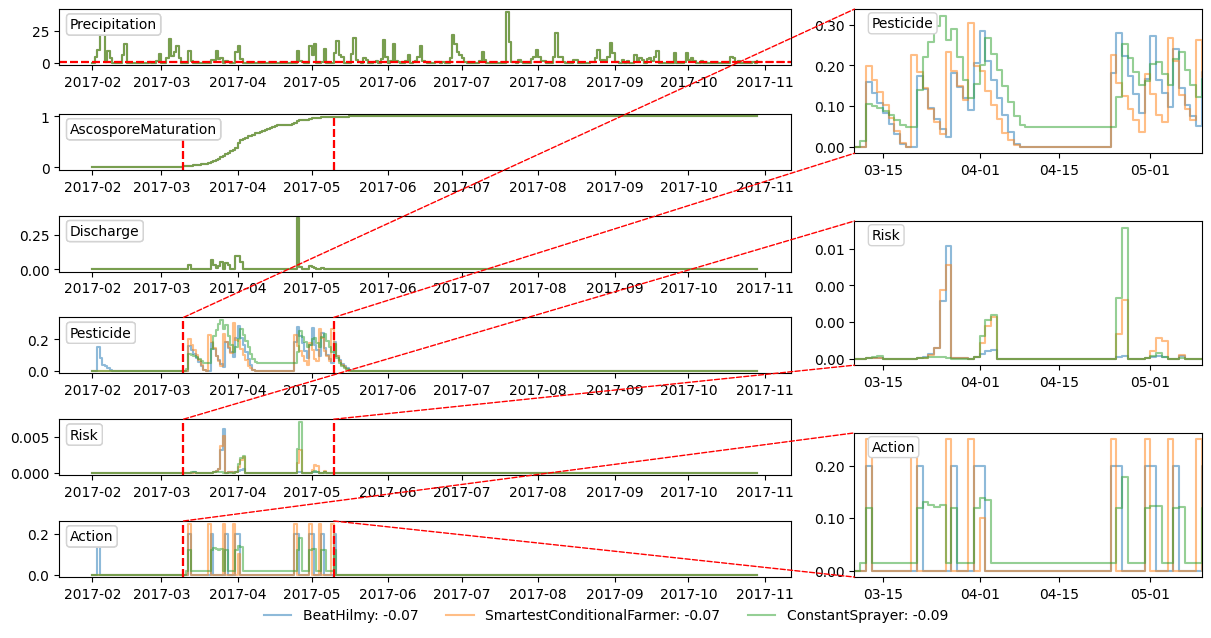

save /content/plot_2019_stacked.png


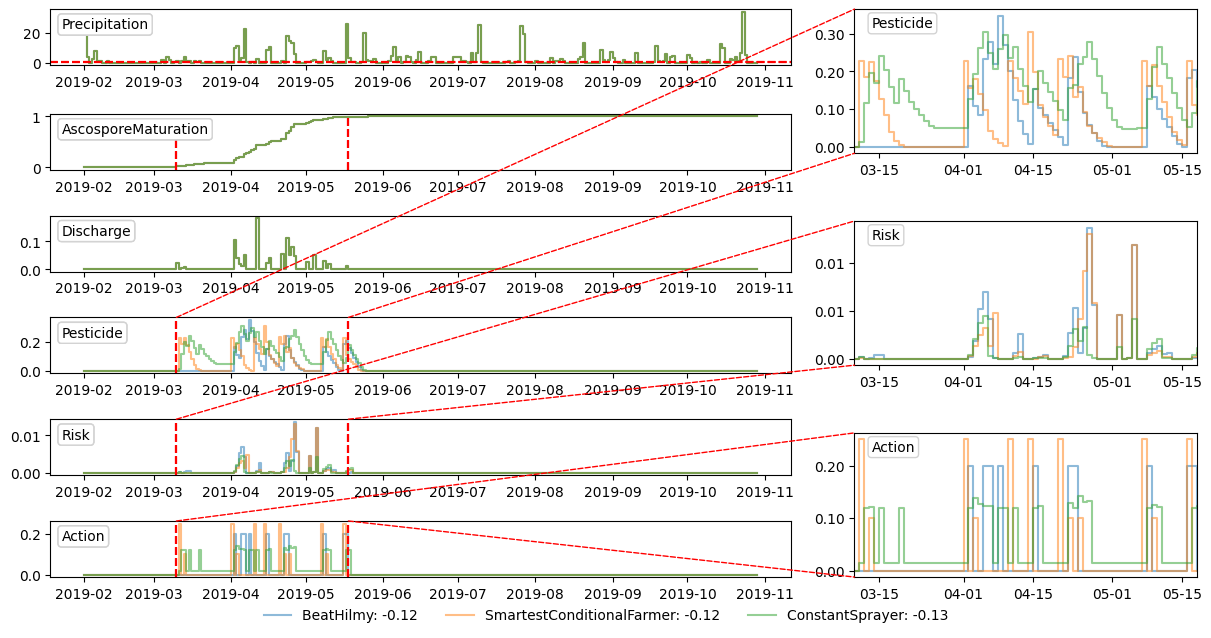

save /content/plot_2021_stacked.png


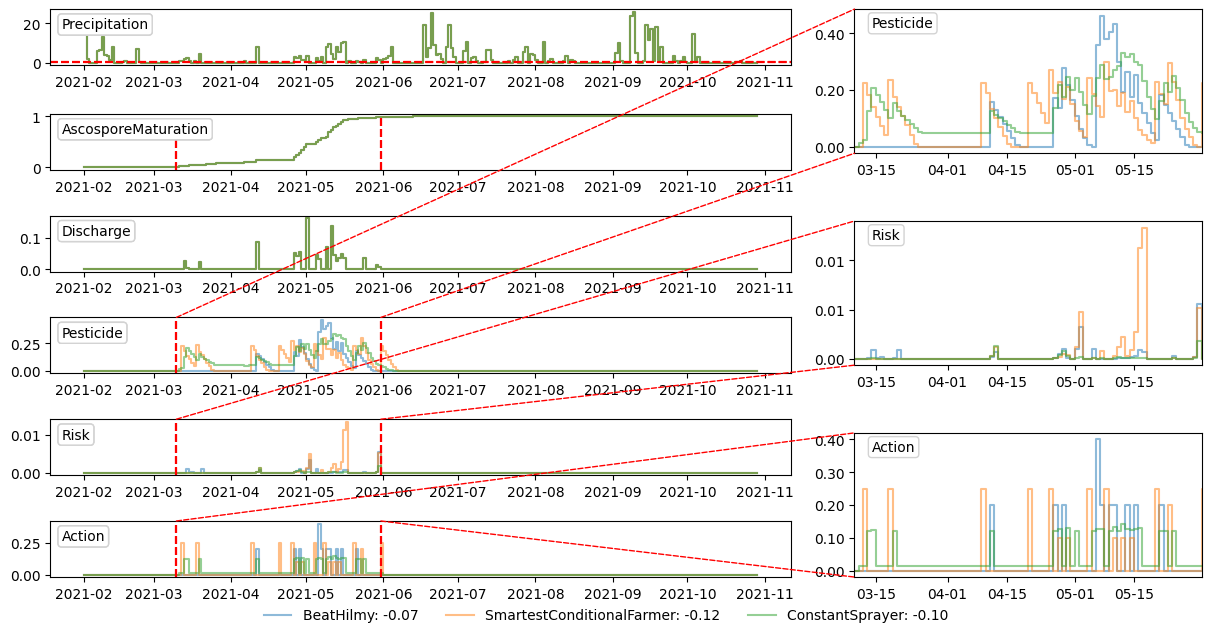

save /content/plot_2023_stacked.png


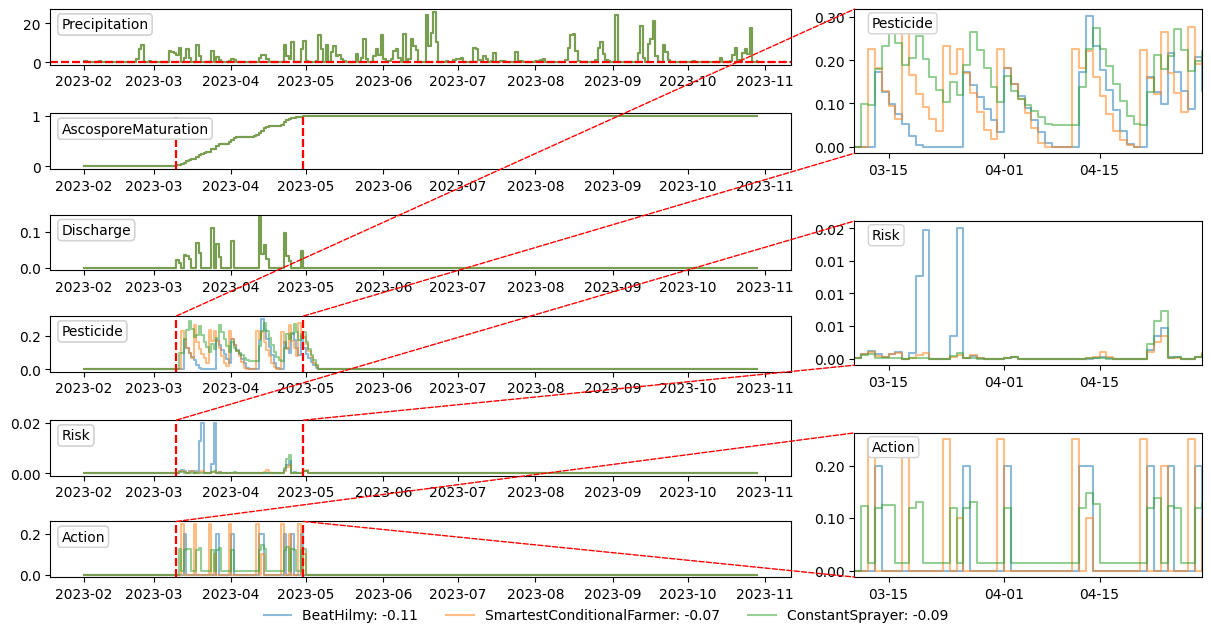

In [56]:
from ascab.utils.plot import plot_results

dict_to_plot = {"BeatHilmy": BeatHilmy_results, "SmartestConditionalFarmer": SmartestConditionalFarmer_results, "ConstantSprayer": ConstantSprayer_results}
plot_results(dict_to_plot,
             save_path=os.getcwd(),
        )